In [47]:
# Importing necessary libraries
from rdkit import Chem, RDLogger
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [48]:
# Disabling RDKit logger
RDLogger.DisableLog("rdApp.*")

In [49]:
# Path to the CSV file containing SMILES data
csv_path = "qm9.csv"

In [50]:
# Reading SMILES data from the CSV file
data = []
with open(csv_path, "r") as f:
    for line in f.readlines()[1:]:
        data.append(line.split(",")[1])

In [51]:
# Selecting a SMILES string from the data
smiles = data[1000]
print("SMILES:", smiles)

SMILES: Cn1cncc1O


Num heavy atoms: 7


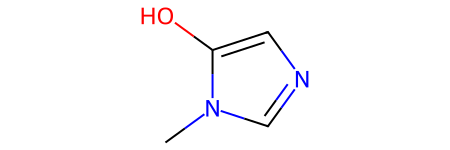

In [52]:
# Converting the SMILES string to an RDKit molecule object
molecule = Chem.MolFromSmiles(smiles)
print("Num heavy atoms:", molecule.GetNumHeavyAtoms())
molecule

In [53]:
# Mapping atom symbols to integers and vice versa
atom_mapping = {
    "C": 0,
    0: "C",
    "N": 1,
    1: "N",
    "O": 2,
    2: "O",
    "F": 3,
    3: "F",
}

In [54]:
# Mapping bond types to integers and vice versa
bond_mapping = {
    "SINGLE": 0,
    0: Chem.BondType.SINGLE,
    "DOUBLE": 1,
    1: Chem.BondType.DOUBLE,
    "TRIPLE": 2,
    2: Chem.BondType.TRIPLE,
    "AROMATIC": 3,
    3: Chem.BondType.AROMATIC,
}

In [55]:
# Constants for graph generation
NUM_ATOMS = 9
ATOM_DIM = 4 + 1
BOND_DIM = 4 + 1
LATENT_DIM = 64

In [56]:
# Function to convert a SMILES string to a graph representation
def smiles_to_graph(smiles):
    # Converting SMILES to an RDKit molecule object
    molecule = Chem.MolFromSmiles(smiles)

    # Initializing adjacency and features matrices
    adjacency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), "float32")
    features = np.zeros((NUM_ATOMS, ATOM_DIM), "float32")

    # Processing atoms and bonds in the molecule
    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = np.eye(ATOM_DIM)[atom_type]
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjacency[bond_type_idx, [i, j], [j, i]] = 1

    # Handling disconnected atoms and empty features
    adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1
    features[np.where(np.sum(features, axis=1) == 0)[0], -1] = 1

    return adjacency, features


In [57]:
# Function to convert a graph representation to an RDKit molecule object
def graph_to_molecule(graph):
    adjacency, features = graph
    molecule = Chem.RWMol() # Creates an rdkit editable molecule (read-write Mol)

    # Selecting atoms and bonds for the final molecule
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)  # This is true for non-PAD (real atoms) and False for PAD atoms 
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)    # Check if each atom participates in any real bond
    )[0] 
    features = features[keep_idx] # has shape (N_kept, ATOM_DIM)
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx] # has shape (BOND_DIM, N_kept, N_kept)

    # Adding atoms to the molecule
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])  #convert type index into chemical element
        _ = molecule.AddAtom(atom)

    # Adding bonds to the molecule
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1) # np.triu ensures you count each edge once (only the upper triangle, i ≤ j).
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j): # atoms_i - row atom index, atoms_j- column atom index.
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:   # Skip self-loops and no-bond channel
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)  # RDKit bond type and add

    # Checking and sanitizing the molecule
    flag = Chem.SanitizeMol(molecule, catchErrors=True) # checks and fixes any wrong valence counts, aromaticity flags, charges, implicit and explicit hydrogens.
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:   # None if invalid, otherwise the final Mol
        return None

    return molecule


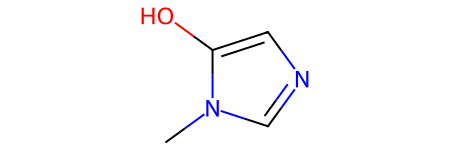

In [58]:
# Generating graph representation for a given SMILES string
graph_to_molecule(smiles_to_graph(smiles))


In [59]:
# Converting a subset of SMILES data to graph tensors
adjacency_tensor, feature_tensor = [], []
for smiles in data[::10]:
    adjacency, features = smiles_to_graph(smiles)
    adjacency_tensor.append(adjacency)
    feature_tensor.append(features)
adjacency_tensor = np.array(adjacency_tensor)
feature_tensor = np.array(feature_tensor)
print("adjacency_tensor.shape =", adjacency_tensor.shape)
print("feature_tensor.shape =", feature_tensor.shape)

adjacency_tensor.shape = (13389, 5, 9, 9)
feature_tensor.shape = (13389, 9, 5)


In [60]:


def GraphGenerator(dense_units, dropout_rate, latent_dim, adjacency_shape, feature_shape):
    z = keras.layers.Input(shape=(latent_dim,))
    x = z

    # Shared dense trunk
    for units in dense_units:
        x = keras.layers.Dense(units, activation="tanh")(x)
        x = keras.layers.Dropout(dropout_rate)(x)

    # Turn shapes into plain ints
    adj_units = int(np.prod(adjacency_shape))
    feat_units = int(np.prod(feature_shape))

    # --- Adjacency branch ---
    x_adjacency = keras.layers.Dense(adj_units)(x)
    x_adjacency = keras.layers.Reshape(adjacency_shape)(x_adjacency)  # (BOND_DIM, N, N)

    # Symmetrize: A = (A + A^T) / 2  along last two dims
    x_adj_T = keras.layers.Permute((1, 3, 2))(x_adjacency)  # (BOND_DIM, j, i)
    x_adjacency = keras.layers.Average()([x_adjacency, x_adj_T])

    x_adjacency = keras.layers.Softmax(axis=1)(x_adjacency)  # softmax over bond types

    # --- Feature branch ---
    x_features = keras.layers.Dense(feat_units)(x)
    x_features = keras.layers.Reshape(feature_shape)(x_features)      # (N, ATOM_DIM)
    x_features = keras.layers.Softmax(axis=2)(x_features)             # over atom types

    return keras.Model(inputs=z, outputs=[x_adjacency, x_features], name="Generator")


In [61]:
# Function to create the generator model
def GraphGenerator(dense_units, dropout_rate, latent_dim, adjacency_shape, feature_shape):
    # NOTE: keep using global LATENT_DIM like original
    z = keras.layers.Input(shape=(LATENT_DIM,))
    x = z
    for units in dense_units:
        x = keras.layers.Dense(units, activation="tanh")(x)
        x = keras.layers.Dropout(dropout_rate)(x)

    # Use plain Python ints instead of tf.math.reduce_prod (avoids dtype errors)
    adj_units = int(np.prod(adjacency_shape))
    feat_units = int(np.prod(feature_shape))

    # Adjacency branch
    x_adjacency = keras.layers.Dense(adj_units)(x)
    x_adjacency = keras.layers.Reshape(adjacency_shape)(x_adjacency)

    # Symmetrize using a Lambda (so Keras is happy with tf.transpose)
    x_adjacency = keras.layers.Lambda(
        lambda a: (a + tf.transpose(a, (0, 1, 3, 2))) / 2.0
    )(x_adjacency)

    x_adjacency = keras.layers.Softmax(axis=1)(x_adjacency)

    # Feature branch
    x_features = keras.layers.Dense(feat_units)(x)
    x_features = keras.layers.Reshape(feature_shape)(x_features)
    x_features = keras.layers.Softmax(axis=2)(x_features)

    return keras.Model(inputs=z, outputs=[x_adjacency, x_features], name="Generator")


In [62]:
# Creating the generator model
generator = GraphGenerator(
    dense_units=[128, 256, 512],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)
generator.summary()


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 128)       │      8,320 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 128)       │          0 │ dense_32[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 256)       │     33,024 │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 256)       │          0 │ dense_33[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 512)       │    131,584 │ dropout_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 512)       │          0 │ dense_34[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 405)       │    207,765 │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_8 (Reshape) │ (None, 5, 9, 9)   │          0 │ dense_35[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 45)        │     23,085 │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 5, 9, 9)   │          0 │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_9 (Reshape) │ (None, 9, 5)      │          0 │ dense_36[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_8 (Softmax) │ (None, 5, 9, 9)   │          0 │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_9 (Softmax) │ (None, 9, 5)      │          0 │ reshape_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 403,778 (1.54 MB)

 Trainable params: 403,778 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
# Class for relational graph convolutional layer
class RelationalGraphConvLayer(keras.layers.Layer):
    def __init__(self, units=128, activation="relu", use_bias=False, kernel_initializer="glorot_uniform",
                 bias_initializer="zeros", kernel_regularizer=None, bias_regularizer=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)

    def build(self, input_shape):
        bond_dim = input_shape[0][1]
        atom_dim = input_shape[1][2]
        self.kernel = self.add_weight(
            shape=(bond_dim, atom_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            trainable=True,
            name="W",
            dtype=tf.float32,
        )
        if self.use_bias:
            self.bias = self.add_weight(
                shape=(bond_dim, 1, self.units),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                trainable=True,
                name="b",
                dtype=tf.float32,
            )
        self.built = True

    def call(self, inputs, training=False):
        adjacency, features = inputs
        x = tf.matmul(adjacency, features[:, None, :, :])
        x = tf.matmul(x, self.kernel)
        if self.use_bias:
            x += self.bias
        x_reduced = tf.reduce_sum(x, axis=1)
        return self.activation(x_reduced)


In [64]:
# Function to create the discriminator model
def GraphDiscriminator(gconv_units, dense_units, dropout_rate, adjacency_shape, feature_shape):
    adjacency = keras.layers.Input(shape=adjacency_shape)
    features = keras.layers.Input(shape=feature_shape)
    features_transformed = features
    for units in gconv_units:
        features_transformed = RelationalGraphConvLayer(units)([adjacency, features_transformed])
    x = keras.layers.GlobalAveragePooling1D()(features_transformed)
    for units in dense_units:
        x = keras.layers.Dense(units, activation="relu")(x)
        x = keras.layers.Dropout(dropout_rate)(x)
    x_out = keras.layers.Dense(1, dtype="float32")(x)
    return keras.Model(inputs=[adjacency, features], outputs=x_out)


In [65]:
# Creating the discriminator model
discriminator = GraphDiscriminator(
    gconv_units=[128, 128, 128, 128],
    dense_units=[512, 512],
    dropout_rate=0.2,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)
discriminator.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 5, 9, 9)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 9, 5)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relational_graph_c… │ (None, 9, 128)    │      3,200 │ input_layer_13[0… │
│ (RelationalGraphCo… │                   │            │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relational_graph_c… │ (None, 9, 128)    │     81,920 │ input_layer_13[0… │
│ (RelationalGraphCo… │                   │            │ relational_graph… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relational_graph_c… │ (None, 9, 128)    │     81,920 │ input_layer_13[0… │
│ (RelationalGraphCo… │                   │            │ relational_graph… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relational_graph_c… │ (None, 9, 128)    │     81,920 │ input_layer_13[0… │
│ (RelationalGraphCo… │                   │            │ relational_graph… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ relational_graph… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 512)       │     66,048 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 512)       │          0 │ dense_37[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 512)       │    262,656 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 512)       │          0 │ dense_38[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 1)         │        513 │ dropout_24[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 578,177 (2.21 MB)

 Trainable params: 578,177 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
# Class for the graph Wasserstein GAN
class GraphWGAN(keras.Model):
    def __init__(self, generator, discriminator, discriminator_steps=1, generator_steps=1, gp_weight=10, **kwargs):
        super().__init__(**kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.discriminator_steps = discriminator_steps
        self.generator_steps = generator_steps
        self.gp_weight = gp_weight
        self.latent_dim = self.generator.input_shape[-1]

    def compile(self, optimizer_generator, optimizer_discriminator, **kwargs):
        super().compile(**kwargs)
        self.optimizer_generator = optimizer_generator
        self.optimizer_discriminator = optimizer_discriminator
        self.metric_generator = keras.metrics.Mean(name="loss_gen")
        self.metric_discriminator = keras.metrics.Mean(name="loss_dis")

    def train_step(self, inputs):
        if isinstance(inputs[0], tuple):
            inputs = inputs[0]
        graph_real = inputs
        self.batch_size = tf.shape(inputs[0])[0]

        for _ in range(self.discriminator_steps):
            z = tf.random.normal((self.batch_size, self.latent_dim))
            with tf.GradientTape() as tape:
                graph_generated = self.generator(z, training=True)
                loss = self._loss_discriminator(graph_real, graph_generated)
            grads = tape.gradient(loss, self.discriminator.trainable_weights)
            self.optimizer_discriminator.apply_gradients(zip(grads, self.discriminator.trainable_weights))
            self.metric_discriminator.update_state(loss)

        for _ in range(self.generator_steps):
            z = tf.random.normal((self.batch_size, self.latent_dim))
            with tf.GradientTape() as tape:
                graph_generated = self.generator(z, training=True)
                loss = self._loss_generator(graph_generated)
                grads = tape.gradient(loss, self.generator.trainable_weights)
                self.optimizer_generator.apply_gradients(zip(grads, self.generator.trainable_weights))
                self.metric_generator.update_state(loss)

        return {m.name: m.result() for m in self.metrics}

    def _loss_discriminator(self, graph_real, graph_generated):
        logits_real = self.discriminator(graph_real, training=True)
        logits_generated = self.discriminator(graph_generated, training=True)
        loss = tf.reduce_mean(logits_generated) - tf.reduce_mean(logits_real)
        loss_gp = self._gradient_penalty(graph_real, graph_generated)
        return loss + loss_gp * self.gp_weight

    def _loss_generator(self, graph_generated):
        logits_generated = self.discriminator(graph_generated, training=True)
        return -tf.reduce_mean(logits_generated)

    def _gradient_penalty(self, graph_real, graph_generated):
        adjacency_real, features_real = graph_real
        adjacency_generated, features_generated = graph_generated
        alpha = tf.random.uniform([self.batch_size])
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1, 1))
        adjacency_interp = (adjacency_real * alpha) + (1 - alpha) * adjacency_generated
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1))
        features_interp = (features_real * alpha) + (1 - alpha) * features_generated
        with tf.GradientTape() as tape:
            tape.watch(adjacency_interp)
            tape.watch(features_interp)
            logits = self.discriminator([adjacency_interp, features_interp], training=True)
        grads = tape.gradient(logits, [adjacency_interp, features_interp])
        grads_adjacency_penalty = (1 - tf.norm(grads[0], axis=1)) ** 2
        grads_features_penalty = (1 - tf.norm(grads[1], axis=2)) ** 2
        return tf.reduce_mean(
            tf.reduce_mean(grads_adjacency_penalty, axis=(-2, -1)) +
            tf.reduce_mean(grads_features_penalty, axis=(-1))
        )


In [67]:
def load_smiles(csv_path):
    """Load SMILES exactly like your original code."""
    data = []
    with open(csv_path, "r") as f:
        for line in f.readlines()[1:]:
            data.append(line.split(",")[1].strip())
    return data


def build_graph_tensors(smiles_list, stride=10):
    """Convert a subset of SMILES to adjacency/feature tensors."""
    adjacency_tensor, feature_tensor = [], []
    for smiles in smiles_list[::stride]:
        adjacency, features = smiles_to_graph(smiles)
        adjacency_tensor.append(adjacency)
        feature_tensor.append(features)

    adjacency_tensor = np.array(adjacency_tensor, dtype="float32")
    feature_tensor = np.array(feature_tensor, dtype="float32")

    print("adjacency_tensor.shape =", adjacency_tensor.shape)
    print("feature_tensor.shape =", feature_tensor.shape)
    return adjacency_tensor, feature_tensor


def build_models():
    """Create generator, discriminator, and WGAN using your existing builders."""
    generator = GraphGenerator(
        dense_units=[128, 256, 512],
        dropout_rate=0.2,
        latent_dim=LATENT_DIM,
        adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
        feature_shape=(NUM_ATOMS, ATOM_DIM),
    )
    discriminator = GraphDiscriminator(
        gconv_units=[128, 128, 128, 128],
        dense_units=[512, 512],
        dropout_rate=0.2,
        adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
        feature_shape=(NUM_ATOMS, ATOM_DIM),
    )
    wgan = GraphWGAN(generator, discriminator, discriminator_steps=1)
    wgan.compile(
        optimizer_generator=keras.optimizers.Adam(5e-4),
        optimizer_discriminator=keras.optimizers.Adam(5e-4),
    )
    return wgan, generator, discriminator





In [68]:
def train_and_save(
    csv_path,
    epochs=10,
    batch_size=16,
    stride=10,
    gen_weights_path="./my_model/generator.weights.h5",
    disc_weights_path="./my_model/discriminator.weights.h5",
):
    """High-level function: load data, train WGAN, save weights."""
    smiles_list = load_smiles(csv_path)
    adjacency_tensor, feature_tensor = build_graph_tensors(smiles_list, stride=stride)

    wgan, generator, discriminator = build_models()

    wgan.fit([adjacency_tensor, feature_tensor], epochs=epochs, batch_size=batch_size)

    generator.save_weights(gen_weights_path)
    discriminator.save_weights(disc_weights_path)

    print("Saved generator weights to:", gen_weights_path)
    print("Saved discriminator weights to:", disc_weights_path)
    return wgan, generator, discriminator

In [69]:
# Training the GraphWGAN model

wgan, generator, discriminator = train_and_save(csv_path, epochs=10, batch_size=16)



adjacency_tensor.shape = (13389, 5, 9, 9)
feature_tensor.shape = (13389, 9, 5)
Epoch 1/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - loss: 0.0000e+00 - loss_dis: -3.8677 - loss_gen: 2.1580
Epoch 2/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.0000e+00 - loss_dis: -1.1969 - loss_gen: 0.7492
Epoch 3/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.0000e+00 - loss_dis: -1.4752 - loss_gen: 0.3246
Epoch 4/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.0000e+00 - loss_dis: -1.5576 - loss_gen: 0.1999
Epoch 5/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.0000e+00 - loss_dis: -1.2868 - loss_gen: 0.1318    
Epoch 6/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 0.0000e+00 - loss_dis: -1.4304 - loss_gen: 0.3513
Epoch 7/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.0000e+00 - loss_dis: -1.5608 - loss_gen: 0.1163
Epoch 8/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.0000e+00 - loss_dis: -1.4805 - loss_gen: 0.2957
Epoch 9/10
837/837 ━━